

# Ephaptic Coupling #

### Import stuff

In [1]:
%pylab inline

import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
from os.path import join
import LFPy
import neuron
from neuron import h

Populating the interactive namespace from numpy and matplotlib


### Define morphology and cell parameters

In [2]:
cellParameters = {
    'morphology' : 'morphology/purkinje.hoc',
    'cm' : 0.65,                   
    'Ra' : 120,                
    'v_init' : -62,  
    'passive' : True,           # turn on NEURONs passive mechanism for all sections
    'nsegs_method' : None,      # spatial discretization method
    'dt' : 2**-6,               # simulation time step size
    'tstart' : 0,               # start time of simulation
    'tstop' : 400,               # stop simulation
    'celsius': 34,
    'pt3d' : True,
    'extracellular': True,
    'passive_parameters' : {'g_pas' : 1/120236, 'e_pas' : -62},
}

### Create generator_cell

In [3]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
generator_cell = LFPy.Cell(**cellParameters)
# align cell
generator_cell.set_rotation(x=4.729, y=-3.166)

# create synapse
synapse_parameters = {
    'idx' : generator_cell.get_closest_idx(x=0, y=0, z=0),  # place sinapse at soma coordinates
    'e' : 0,                     # reversal potential
    'syntype' : 'ExpSyn',        # synapse type
    'tau' : 7.6,                 # purkinje synaptic time constant
    'weight' : 0.003,            # synaptic weight
    'record_current' : True,     # record synapse current
}

synapse = LFPy.Synapse(generator_cell, **synapse_parameters)
synapse.set_spike_times(np.array([95, 195]))      # spike times

	1 
	30 
	0 
	0 
	0 
	0 
Purkinje cell morphology defined

	1 


### Create grid electrode (for contour plot) and point electrode (for simple plots)

In [4]:
# create a grid of measurement locations, in (mum)
#X, Z = np.mgrid[-300:300:20, -150:1200:10]  #Zoom
X, Z = np.mgrid[-150:220:10, -100:250:10]
Y = np.zeros(X.shape)

# define electrode parameters
grid_electrode_parameters = {
    'sigma' : 0.6,             # extracellular conductivity
    'x' : X.flatten(),         # electrode requires 1d vector of positions
    'y' : Y.flatten(),
    'z' : Z.flatten(),
    'verbose': True,
}

# define electrode parameters
point_electrode_parameters = {
    'sigma' : 0.6,                    # extracellular conductivity
    'x' : np.array([80.44137469, 19.73905182]),     # positions of the first(blue) and second(green) electrode
    'y' : np.array([   0.,    0.]),
    'z' : np.array([   47.26621657,  170.46665192]),
}

# run simulation, electrode object argument in cell.simulate
generator_cell.simulate(rec_imem=True)

# create electrode objects
grid_electrode = LFPy.RecExtElectrode(generator_cell,**grid_electrode_parameters)
point_electrode = LFPy.RecExtElectrode(generator_cell,**point_electrode_parameters)

# calculate LFPs
grid_electrode.calc_lfp()
point_electrode.calc_lfp()

calculations finished, <LFPy.recextelectrode.RecExtElectrode object at 0x7f30f71abc10>, <LFPy.cell.Cell object at 0x7f30f71abb90>


### Plot generator and receptor cells

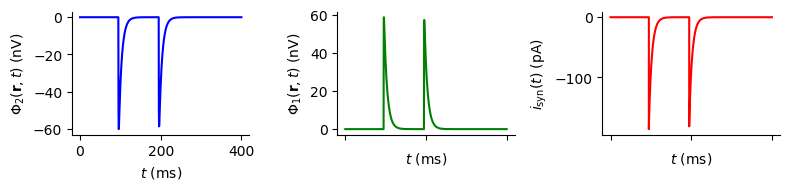

In [5]:
plt.figure(figsize=(8, 2), dpi=100)
# plot LFP blue electrode [0]
plt.subplot(1,3,1)
plt.plot(generator_cell.tvec,point_electrode.LFP[0]*1e6,color='blue', clip_on=False)
plt.ylabel(r'$\Phi_2(\mathbf{r},t)$ (nV)')
plt.xlabel(r'$t$ (ms)')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot LFP green electrode
plt.subplot(1,3,2)
plt.plot(generator_cell.tvec,point_electrode.LFP[1]*1e6,color='green', clip_on=False)
plt.ylabel(r'$\Phi_1(\mathbf{r}, t)$ (nV)')
plt.xlabel(r'$t$ (ms)')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])

# plot synapse electrode
plt.subplot(1,3,3)
plt.plot(generator_cell.tvec,synapse.i*1E3, color='red', clip_on=False)
plt.ylabel(r'$i_\mathrm{syn}(t)$ (pA)')
plt.xlabel(r'$t$ (ms)')
ax = plt.gca()
for loc, spine in ax.spines.items():
    if loc in ['right', 'top']:
        spine.set_color('none')            
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels([])

plt.tight_layout()

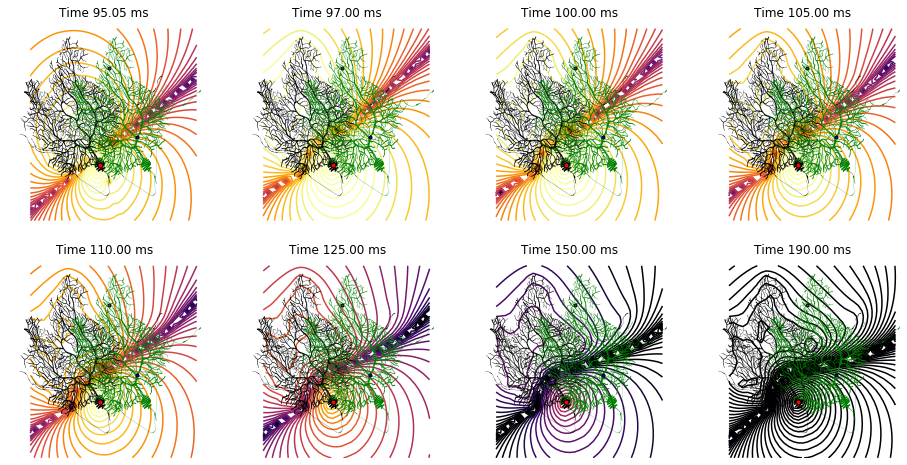

In [12]:
def ctime(t,ax=None,vmin=-8,vmax=-4):
    
    ax = plt.gca() if ax == None else ax

    #LFP = np.max(np.abs(grid_electrode.LFP),1).reshape(X.shape)  
    LFP = np.abs(grid_electrode.LFP[:,t]).reshape(X.shape)  

    im = ax.contour(X, Z, np.log10(LFP), 40,
               cmap='inferno', vmin=vmin, vmax=vmax,  #'viridis', 'plasma', 'inferno', 'magma', 'cividis' https://matplotlib.org/tutorials/colors/colormaps.html#mycarta-banding
               zorder=-2)
    #cbar = fig.colorbar(im, cax=cax)
    #cbar.set_label('$|\Phi(\mathbf{r}, t)|$ (nV)')
    #cbar.outline.set_visible(False)
    
    # plot points where the synapse is
    ax.plot(generator_cell.xmid[generator_cell.synidx],generator_cell.zmid[generator_cell.synidx], 'o', ms=5,
        markeredgecolor='k',
        markerfacecolor='r')

    # plot points where the LFP is been recorded
    color_vec = ['blue','green']
    for i in range(2):
        ax.plot(point_electrode_parameters['x'][i], point_electrode_parameters['z'][i],'o',ms=3, markeredgecolor='k',
            markerfacecolor=color_vec[i])
    
    # plot morphology of generator_cell
    zips = []
    for x, z in generator_cell.get_idx_polygons():
        zips.append(list(zip(x, z)))
    polycol = PolyCollection(zips,
                             edgecolors='none',
                             facecolors='k')
    ax.add_collection(polycol)

    # plot morphology of receptor_cell
    shift = 100          # shift of receptor_cell in x dimension
    zips = []
    for x, z in generator_cell.get_idx_polygons():
        zips.append(list(zip(x+shift, z)))
    polycol = PolyCollection(zips,
                             edgecolors='none',
                             facecolors= 'green')
    ax.add_collection(polycol)

    ax.set_ylim(-100,250) #ZOOM
    ax.set_xlim(-200,220)
    ax.axis('off')
    
fig,axes = plt.subplots(2,4,figsize=(16,8))
times = [int(95.05/(2**-6)),int(97/(2**-6)),int(100/(2**-6)),int(105/(2**-6)),int(110/(2**-6)),int(125/(2**-6)),
         int(150/(2**-6)),int(190/(2**-6))]
for t,ax in zip(times,axes.ravel()):
    ctime(t,ax=ax)
    ax.set_title('Time %.2f ms'%(t*2**-6))

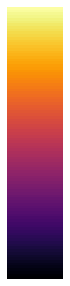

In [7]:
plt.figure(figsize=(1,5))
plt.imshow(np.linspace(-8,-5,100).reshape(-1,1),vmin=-8,vmax=-5,cmap='inferno', aspect='auto',origin='uper')
plt.gca().set_axis_off()
#Black = -8 - 0.01
#Blue = -7  - 0.1
#Purple = -6 - 1 (nV)
#Orange = -5 - 10
#yellow = -4 - 100
#mv(-3) --> nV(-9)
#MODULE OF V() (nv)


In [8]:
#Histograma para definir os limites vmin e vmax
#plt.hist(np.log10(np.abs(grid_electrode.LFP.ravel())),30)

In [9]:
print(np.abs(grid_electrode.LFP[1,t]))

2.824760675932152e-11
